In [27]:
%load_ext autoreload

%autoreload 2

from models import vgg11_Syntetic, vgg_preprocess
import torch
import numpy as np
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
torch.manual_seed(123)
np.random.seed(123)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [90]:
model = vgg11_Syntetic().to(device)
model.load_state_dict(torch.load("./VGG11_Synthetic.pth", map_location=device))
preprocess = vgg_preprocess

In [107]:
from data import SynteticFigures
from torchvision.transforms import InterpolationMode

TEST_SIZE = 256
BATCH_SIZE = 2

background_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
])

mask_preprocess = transforms.Compose([
        transforms.Resize((224, 224), interpolation=InterpolationMode.NEAREST),
        # transforms.GaussianBlur(5),
        transforms.ToTensor(),  # Convert to Tensor
])

data_test = SynteticFigures(background_path="./data/Waldo",
                            num_images=TEST_SIZE,
                            split='test',
                            num_shapes_per_image=3,
                            image_transform=preprocess,
                            background_transform=background_transform,
                            mask_preprocess=mask_preprocess)

test_dl = DataLoader(data_test, BATCH_SIZE, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([2, 3, 224, 224]) torch.Size([2])


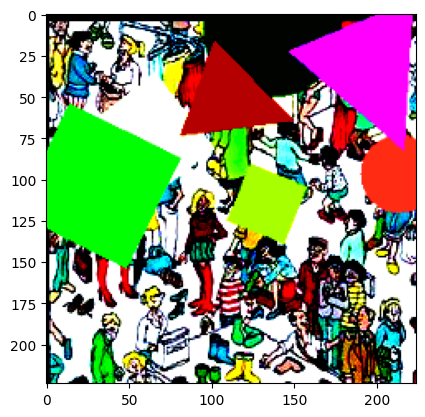

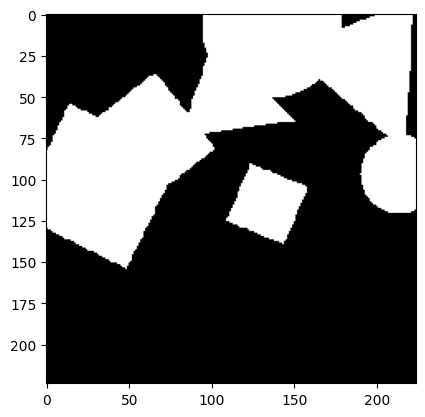

In [110]:
for images,mask, labels in test_dl:
    print(images.shape, labels.shape)
    plt.imshow(images[0].permute(1,2,0))
    plt.show()
    plt.imshow(mask[0].permute(1,2,0))
    plt.show()
    break

Now we compare the ground truth attribution map (e.g. the binary mask) to the one created using various attribution methods.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([2, 1, 224, 224])


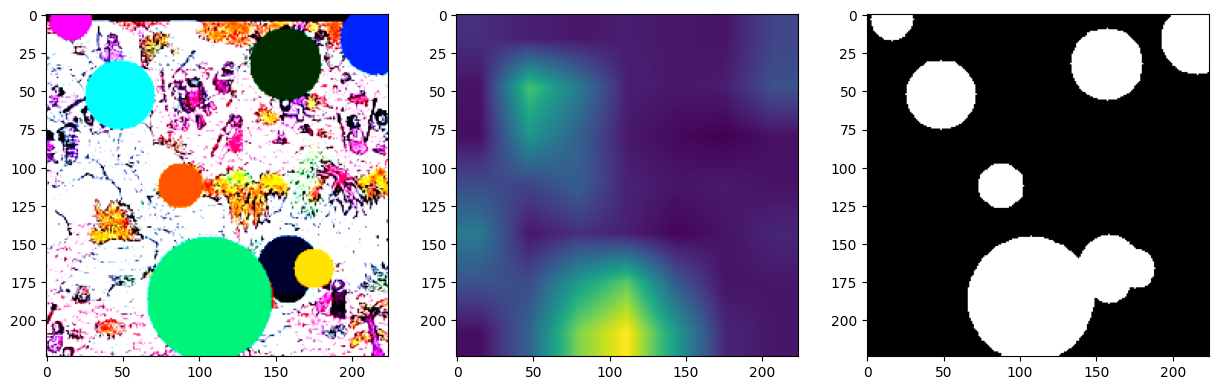

In [106]:
from utils import _GradCAMPlusPlus, SimpleUpsampling

attribute_method = _GradCAMPlusPlus(model, model.features[-1])
upsample = SimpleUpsampling((224,224))
for images, masks, labels in test_dl:
    labels = labels.to(device).reshape(-1)
    images = images.to(device)

    attributions = attribute_method.attribute(
        input_tensor=images,
        model=model,
        layer=model.features[-1],
        target=labels,
        baseline_dist=None,
    )

    attributions = upsample(attributions, None)

    print(attributions.shape)

    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.imshow(images[0].permute(1,2,0))
    plt.subplot(1,3,2)
    # plt.show()
    plt.imshow(attributions[0][0])
    plt.subplot(1,3,3)
    
    # plt.show()
    plt.imshow(masks[0].permute(1,2,0))
    break

